<a href="https://colab.research.google.com/github/LYZAcell/data_study/blob/main/BDA(%ED%8C%90%EB%8B%A4%EC%8A%A4)/%EB%B3%B5%EC%8A%B5_%EC%9D%B4%EA%B0%80%EC%98%8141_1117.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PPT

1. 이상치는 왜 발생하나?
- 데이터 입력오류
- 측정오류
- 샘플링 오류
- 자연발생 이상치
- 데이터 처리 오류

2. IQR : 4분위수
- min, Q1, median, Q3, max

3. Isolation Forest
- 랜덤 서브 샘플링을 통해 일부만 이상치 탐지 -> 1~10% 데이터 샘플링
- 랜덤 분할, 재귀 분할
- 결정트리 구조 : 각 트리 경로에서 데이터가 분리되고 분할 횟수가 적을수록 트리가 얕아짐. 이는 이상치일 확률이 높다
- 이상치 점수: 각 데이터 포인트의 분리길이 기반으로 계산, 데이터 포인트의 평균 분리 깊이, 샘플 크기에 대한 상수 조정 계산

4. DBSCAN 밀도 기반 군집화 알고리즘
- 데이터영역(클러스터) 식별하고도 밀도가 낮은 영역을 이상치(노이즈)로 간주
- core_point:핵심점 반지름 내 최소이상의 데이터 포인트가 있는 점
- Border Point 경계점: core_point보다는 적지만 핵심점의 반지름 내에 포화되는 점 클래스터의 경계의 의미
- Noise: 이상치

5. LOF : Local Outlier Factor
- 밀도 기반 이상치 탐지 알고리즘 : 데이터포인트가 주변 데이터 포인트에 비해 얼마나 밀도가 낮은지 평가하여 이상치 탐지. local 지역적 밀도 계산
- 특정 데이터가 속한 지역의 밀도와 주변 지역의 밀도를 비교한다. 이상치는 주변 지역에 비해 상대적으로 밀도가 낮은 데이터 포인트로 간주된다
- 밀도기반으로 이상값을 찾는 알고리즘으로 다차원 공간 안에서 **이상값들은 주위밀도에 비해 밀도가 낮다는 점**에서 시작된 알고리즘.

그외...
- 슈하르트 : 시계열데이터 이상치 탐지
- STL Decomposition
- Arima

# 코드

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import KNNImputer
import pandas as pd

import seaborn as sns

In [2]:
titanic = sns.load_dataset('titanic')

In [3]:
results = pd.DataFrame(columns = ['Method','Dataset','Accuracy','Precision','Recall','F1'])

#결측치 모두 제거
def drop_na(df):
    return df.dropna(subset=['age']) #컬럼을 지정할 수 있음

#평균으로 대치
def mean_imputation(df):
    df_filled = df.copy()
    df_filled['age'].fillna(df_filled['age'].mean(), inplace=True)
    return df_filled

#선형보간으로
def linear_interpolation(df):
    df_filled = df.copy()
    df_filled['age'].interpolate(method='linear',inplace=True)
    return df_filled

#KNN으로 진행
def knn_imputation(df,n_neighbors =5):
    df_filled = df.copy()
    imputer=KNNImputer(n_neighbors = n_neighbors)
    df_filled[['age']]=imputer.fit_transform(df_filled[['age']])
    return df_filled


#다양한 방법으로 결측치를 보간하고 RF 모델에 학습시켜 train,test의 생존율 예측 결과를 확인하자!

# 각 방법을 적용하여 성능 테스트
methods = {
    'Drop NA': drop_na,
    'Mean Imputation':mean_imputation,
    'Linear Interpolation':linear_interpolation,
    'Knn Imputation' : knn_imputation
}

## 타이타닉 데이터로 반복을 돌려서 방법들을 다 하나씩 돌려서 성능 테스트를 넣어야 한다.
## 데이터를 학습시키기 위해서 train, test 로 나눠야 한다.
## 인코딩하는 get_dummies 인코딩 작업

for method_name, impute_func in methods.items():
    titanic_filled = impute_func(titanic)

    #학습할 데이터셋으로 나누기
    X = titanic_filled.drop(['survived','deck','alone','who','adult_male','alive','embark_town'],axis = 1)
    y = titanic_filled['survived']

    #원핫 인코딩으로 범주형 변수를 수치로 바꾸는 것
    X = pd.get_dummies(X, drop_first=True)

    #데이터셋 분할
    X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=111)

    model = RandomForestClassifier(random_state=111)
    model.fit(X_train, y_train)

    # 성능에 대해서 평가한 것들을 데이터프레임 저장해야 한다.

    for dataset, X_data, y_data in (['Train',X_train, y_train],('Test',X_test, y_test)):
        y_pred = model.predict(X_data)

        #'Accuracy','Precision','Recall','F1'
        accuracy = accuracy_score(y_data, y_pred)
        precision = precision_score(y_data, y_pred)
        recall = recall_score(y_data, y_pred)
        f1 = f1_score(y_data, y_pred)

        #결과 저장
        result_now=pd.DataFrame({
            'Method':[method_name],
            'Dataset':[dataset],
            'Accuracy':[accuracy],
            'Precision':[precision],
            'Recall':[recall],
            'F1':[f1]
        })
        results = pd.concat([results, result_now], ignore_index=True)

print(results)

<ipython-input-3-d17adfc17b00>:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, result_now], ignore_index=True)
<ipython-input-3-d17adfc17b00>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filled['age'].fillna(df_filled['age'].mean(), inplace=T

                 Method Dataset  Accuracy  Precision    Recall        F1
0               Drop NA   Train  0.987741   0.991379  0.978723  0.985011
1               Drop NA    Test  0.776224   0.694915  0.745455  0.719298
2       Mean Imputation   Train  0.984551   0.985348  0.974638  0.979964
3       Mean Imputation    Test  0.826816   0.777778  0.742424  0.759690
4  Linear Interpolation   Train  0.988764   0.996296  0.974638  0.985348
5  Linear Interpolation    Test  0.832402   0.781250  0.757576  0.769231
6        Knn Imputation   Train  0.984551   0.985348  0.974638  0.979964
7        Knn Imputation    Test  0.826816   0.777778  0.742424  0.759690


<ipython-input-3-d17adfc17b00>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filled['age'].fillna(df_filled['age'].mean(), inplace=True)
<ipython-input-3-d17adfc17b00>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

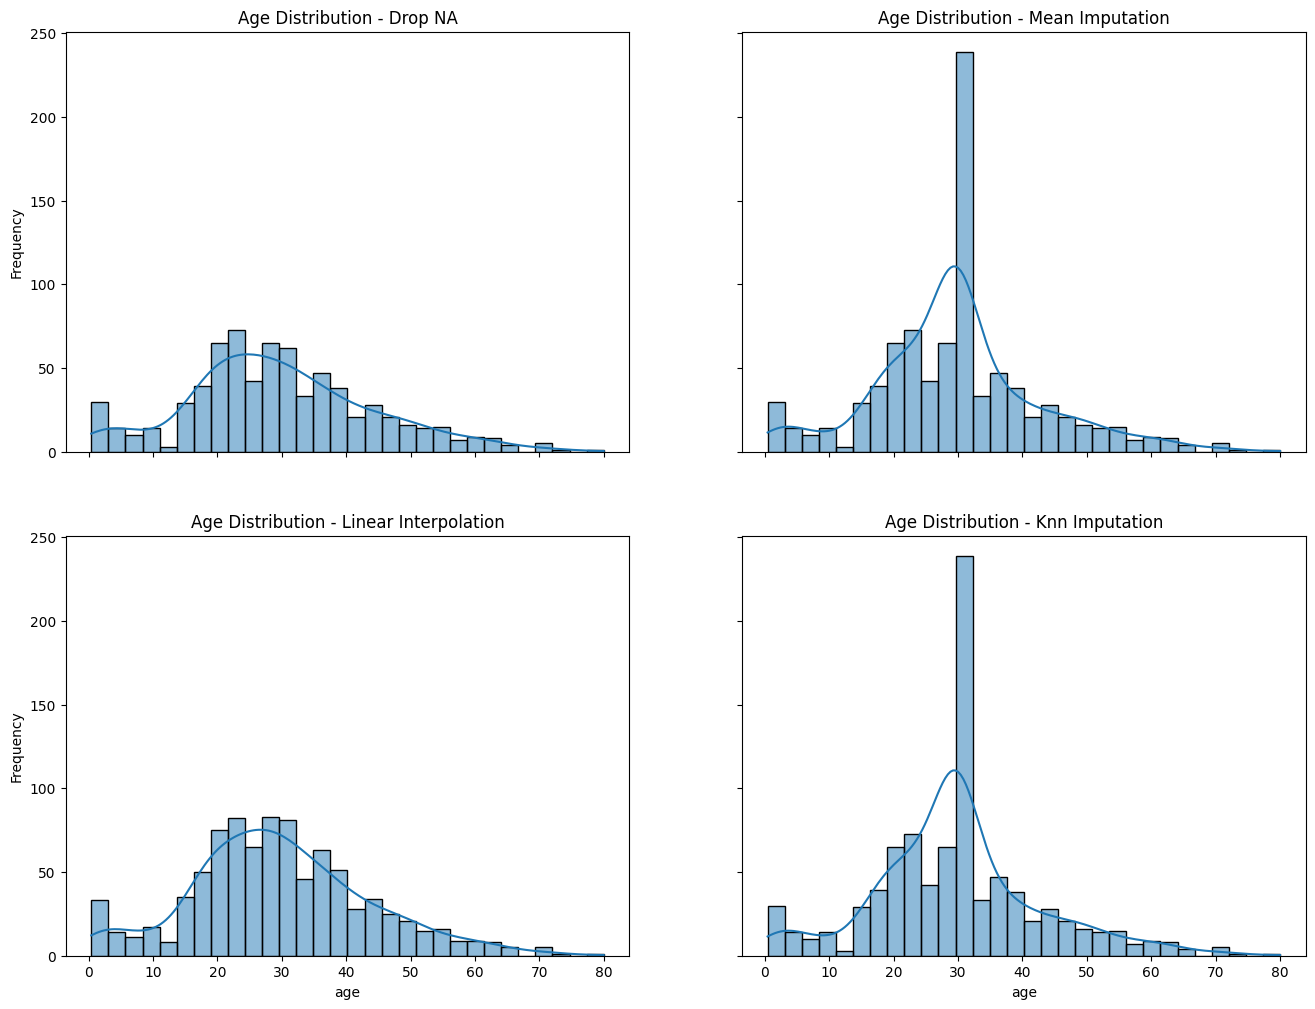

In [4]:
# 시각적으로 어떤 식으로 결측치가 보간 된 걸까?

import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,2, figsize=(16,12), sharex= True, sharey=True)
axes = axes.flatten()

for ax,(method_name, impute_func) in zip (axes, methods.items()):
    titanic_filled = impute_func(titanic)

    ## 분포를 살펴보기

    sns.histplot(titanic_filled['age'], bins= 30, kde=True, ax=ax)
    ax.set_title(f'Age Distribution - {method_name}')
    ax.set_xlabel('age')
    ax.set_ylabel('Frequency')


#plt.subtitle('Method Com')""

In [5]:
import numpy as np
# 예제용 타이타닉 데이터 로드
titanic = sns.load_dataset('titanic')

# 요금 구간을 나누고 나이 결측치를 보간하는 함수 정의
def fill_age_based_on_rules(df):
    # 요금 구간(fare_bin)을 생성하여 결측치 보간 기준을 세분화
    df['fare_bin'] = pd.qcut(df['fare'], q=4, labels=['low', 'mid-low', 'mid-high', 'high'])

    # 성별, 승객 등급, 요금 구간별 평균 나이 계산
    age_means = df.groupby(['sex', 'pclass', 'fare_bin'])['age'].mean()

    # 결측치 보간 함수
    def fill_age(row):
        if np.isnan(row['age']):  # 나이가 결측치인 경우
            try:
                # 성별, 승객 등급, 요금 구간별 평균 나이를 대입
                return age_means[row['sex'], row['pclass'], row['fare_bin']]
            except KeyError:
                # 해당 그룹이 없을 경우 전체 평균으로 대체
                return df['age'].mean()
        return row['age']  # 결측치가 아닌 경우 원래 나이 반환

    # 각 행에 대해 결측치 보간 수행
    df['age'] = df.apply(fill_age, axis=1)
    df.drop(columns=['fare_bin'], inplace=True)  # 임시로 생성한 fare_bin 컬럼 제거
    return df

# 함수 적용
titanic = fill_age_based_on_rules(titanic)

# 결과 확인
print(titanic['age'].isnull().sum())  # 결측치가 없는지 확인

6


<ipython-input-5-7c30c1c88c07>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_means = df.groupby(['sex', 'pclass', 'fare_bin'])['age'].mean()


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 나이 결측치가 채워지지 않은 행 삭제
titanic_cleaned = titanic.dropna(subset=['age'])

# 독립변수와 종속변수 설정
X = titanic_cleaned.drop(['survived', 'deck', 'alone', 'who', 'adult_male', 'alive', 'embark_town'], axis=1)
y = titanic_cleaned['survived']

# 범주형 변수를 원-핫 인코딩
X = pd.get_dummies(X, drop_first=True)

# 학습 및 테스트 데이터셋으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=111)

# 랜덤 포레스트 모델 정의 및 훈련
model = RandomForestClassifier(random_state=111)
model.fit(X_train, y_train)

# 훈련 및 테스트 데이터에 대한 예측값 계산
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 성능 평가 (정확도, 정밀도, 재현율, F1 스코어)
metrics = {
    'Train': {
        'Accuracy': accuracy_score(y_train, y_train_pred),
        'Precision': precision_score(y_train, y_train_pred),
        'Recall': recall_score(y_train, y_train_pred),
        'F1 Score': f1_score(y_train, y_train_pred)
    },
    'Test': {
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred),
        'Recall': recall_score(y_test, y_test_pred),
        'F1 Score': f1_score(y_test, y_test_pred)
    }
}

# 결과 출력
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


              Train      Test
Accuracy   0.981638  0.847458
Precision  0.988722  0.850000
Recall     0.963370  0.739130
F1 Score   0.975881  0.790698


### 이상치 데이터
- 가상의 이상치 데이터를 만들어 보자!
- 제조공정의 데이터로 가정하고 만들어 보자!

In [7]:
np.random.seed(42)

n_samples =500

data = pd.DataFrame({
    'Temperature' : np.random.normal(100,5 ,n_samples),
    'Pressure' : np.random.normal(200,10, n_samples),
    'Speed': np.random.normal(1200,50, n_samples),
    'DefectRate': np.random.normal(2,0.5, n_samples)
})

# 이상치 추가

data.loc[10, 'Temperature'] = 200
data.loc[20, 'Pressure'] = 199
data.loc[30, 'Speed'] = 1189
data.loc[40, 'DefectRate'] = 10

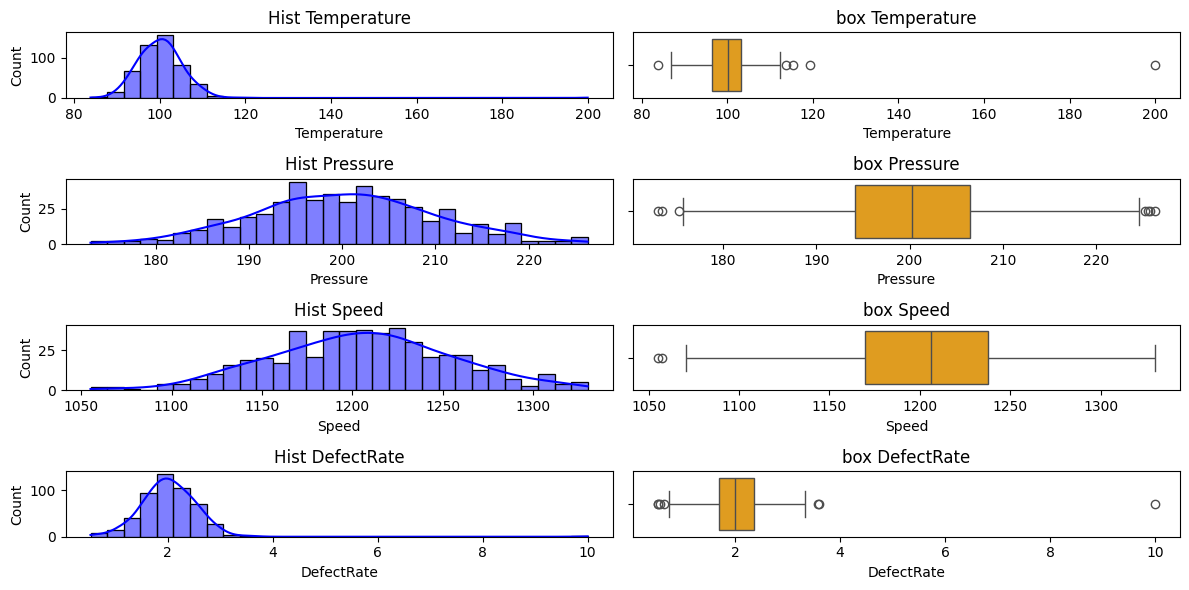

In [8]:
##히스토그램 및 박스플롯으로 살펴보기

fig, axes = plt.subplots(4,2, figsize=(12,6))


for i ,column in enumerate(data.columns):
    sns.histplot(data[column], bins=30, ax = axes[i,0], kde=True, color='blue')
    axes[i,0].set_title(f'Hist {column}')

    sns.boxplot(x=data[column], ax=axes[i,1], color='orange')
    axes[i,1].set_title(f'box {column}')

plt.tight_layout()
plt.show()

In [9]:
## iqr

def detect_outliers_iqr(df,column):
    Q1 = np.percentile(df[column], 25)
    Q3 = np.percentile(df[column], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

##
outliers_iqr={col :detect_outliers_iqr(data,col) for col in data.columns}

In [10]:
outliers_iqr

{'Temperature':      Temperature    Pressure        Speed  DefectRate
 10    200.000000  202.704568  1265.869703    1.429155
 179   113.600846  212.715551  1144.820534    1.784190
 209   119.263657  216.964564  1287.478837    1.512735
 262    83.793663  225.600845  1226.937800    2.037717
 478   115.394404  184.160972  1155.625391    1.613561,
 'Pressure':      Temperature    Pressure        Speed  DefectRate
 44     92.607390  175.283555  1191.368635    1.698894
 146    93.815246  173.031134  1145.186246    1.906428
 154   101.465362  225.733598  1282.100758    2.169242
 168    98.773059  173.490302  1229.737717    2.420310
 255    97.578830  226.323821  1139.517949    2.686829
 262    83.793663  225.600845  1226.937800    2.037717
 380    95.801391  225.269324  1233.896294    2.482426,
 'Speed':      Temperature    Pressure        Speed  DefectRate
 61     99.071705  220.754008  1057.572869    1.626394
 101    97.896773  190.778347  1055.187231    2.687438,
 'DefectRate':      Temper

In [11]:
## IsolationForest

from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination = 0.05, random_state=111)
outlier_flags = iso.fit_predict(data)


In [12]:
outliser_iso = data[outlier_flags==-1]

In [13]:
outliser_iso

,Temperature,Pressure,Speed,DefectRate
10,200.000000,202.704568,1265.869703,1.429155
31,109.261391,183.384799,1116.570796,1.115780
39,100.984306,194.231081,1252.354915,0.563869
40,103.692333,208.356921,1284.196385,10.000000
44,92.607390,175.283555,1191.368635,1.698894
61,99.071705,220.754008,1057.572869,1.626394
101,97.896773,190.778347,1055.187231,2.687438
154,101.465362,225.733598,1282.100758,2.169242
160,95.126592,194.263380,1075.029714,2.658558
179,113.600846,212.715551,1144.820534,1.784190
